## 2D Mult-element airfoil

## Part 1

In [122]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

In [123]:
#Load Flaps - Files easily changed for size
main_foil = os.path.join('MainFoil_N=200.csv')
with open (main_foil, 'r') as file_name:
    x_main, y_main = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    

flap_foil = os.path.join('FlapFoil_N=200.csv')
with open (flap_foil, 'r') as file_name:
    x_flap, y_flap = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    
N = x_flap.size -1

In [124]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
       
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [125]:
def define_panels(x, y, N):
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

In [126]:
class Freestream:
    
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [127]:
#Build freestream condition
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [128]:
main_panels = define_panels(x_main, y_main, N)
flap_panels = define_panels(x_flap, y_flap, N)

#combining both panels
panels = np.append(main_panels, flap_panels)

In [129]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [130]:
#source contribution
def source_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [131]:
def vortex_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [132]:
#Create source and vortex contributions
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [133]:
def kutta_condition(A_source, B_vortex):

    b = np.empty((2,A_source.shape[0]+2), dtype=float)
    A = np.empty((A_source.shape[0], A_source.shape[0]+2), dtype=float)
    
    A[:, :-2] = B_vortex
    A[:, -2] = -np.sum(A_source[:,:N], axis=1)
    A[:, -1] = -np.sum(A_source[:,N:], axis=1)
   
    b[0,:] = A[0, :] + A[N-1, :]
    b[1,:] = A[N, :] + A[-1, :]

    return b

In [134]:
def build_singularity_matrix(A_source, B_vortex):

    A = np.empty((A_source.shape[0]+2, A_source.shape[1]+2), dtype=float)
    A[:-2, :-2] = A_source
    A[:-2, -2] = np.sum(B_vortex[:,:N], axis=1)
    A[:-2, -1] = np.sum(B_vortex[:,N:], axis=1)
    A[-2:, :] = kutta_condition(A_source, B_vortex)


    return A

In [135]:
def build_freestream_rhs(panels, freestream):
   
    b = np.empty(panels.size+2,dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)
    
    b[-2] = -freestream.u_inf*( np.sin(freestream.alpha-panels[0].beta)
                              +np.sin(freestream.alpha-panels[N-1].beta) )
    b[-1] = -freestream.u_inf*( np.sin(freestream.alpha-panels[N].beta)
                              +np.sin(freestream.alpha-panels[-1].beta) )
    return b

In [136]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [137]:
sigmas = np.linalg.solve(A, b)

#store source strength
for i, panel in enumerate(panels):
    panel.sigma = sigmas[i]
    
gamma = sigmas[-2:]


In [138]:
# calculate the accuracy
accuracy1 = sum([panel.sigma * panel.length for panel in panels])
print('sum of strengths for main: {:0.6f}'.format(accuracy1))

sum of strengths for main: -0.000827


In [139]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    
    A = np.empty((panels.size, panels.size + 2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -np.sum(A_source[:,:N], axis=1)
    A[:, -1] = -np.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    strengths = np.append([panel.sigma for panel in panels], gamma)
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [140]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [141]:
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [142]:
# surface pressure coefficient

compute_pressure_coefficient(panels, freestream)

In [143]:
main_cp = os.path.join('Cp_Main_theoretical.csv')
with open (main_cp, 'r') as file_name:
    x_main_cp, y_main_cp = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    

flap_cp = os.path.join('Cp_Flap_theoretical.csv')
with open (flap_cp, 'r') as file_name:
    x_flap_cp, y_flap_cp = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

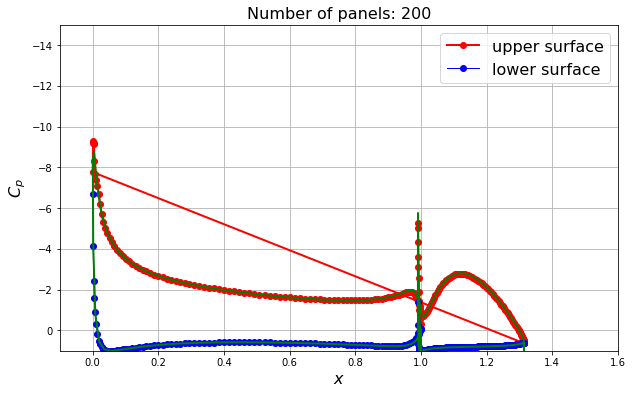

In [144]:
py.figure(figsize=(10, 6))
py.grid()
py.xlabel('$x$', fontsize=16)
py.ylabel('$C_p$', fontsize=16)

py.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'], label='upper surface', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
py.plot([panel.xc for panel in panels if panel.loc == 'lower'], [panel.cp for panel in panels if panel.loc == 'lower'], label= 'lower surface', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

py.plot(x_main_cp, y_main_cp, color='g', linestyle='-', linewidth=2)
py.plot(x_flap_cp, y_flap_cp, color='g', linestyle='-', linewidth=2)



py.legend(loc='best', prop={'size':16})
py.xlim(-0.1, 1.6)
py.ylim(1.0, -15.0)
py.title('Number of panels: {}'.format(main_panels.size), fontsize=16);

In [145]:
#pressure coefficient on the 3rd panel
print('cp on 3rd panel: ', panels[2].cp)

cp on 3rd panel:  -0.553530359708


In [146]:
#cp on the 10th panel
print('cp on 10th flap panel: ', panels[main_panels.size+9].cp)

cp on 10th flap panel:  0.262580530047


In [147]:
#what is the lift?
lift = 0
error = 0
for panel in panels:
    lift -= panel.cp*np.sin(panel.beta)*panel.length
    
print('Lift= ', lift)
print('Error= ', (3.7386-lift))

Lift=  3.71843390868
Error=  0.0201660913188


In [148]:
#what is the drag?
drag = 0
for panel in panels:
    drag -= panel.cp*np.cos(panel.beta)*panel.length
    
print('Drag= ', drag)

Drag=  -0.0055835520559


In [150]:
#w/ 200 pts, whats the improvement in error
#error w/ 100 pts = 0.0408855231392
#error w/ 200 pts = 0.0201660913188
print('Improvement= ', .0201660913188/0.0408855231392*100)

Improvement=  49.3233050978508


## Part 2

In [33]:
#Load files
mainfoil = os.path.join('NACA23012_MainFoil.csv')
with open (mainfoil, 'r') as file_name:
    xmain, ymain = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

flapfoil = os.path.join('NACA23012_FlapFoil.csv')
with open (flapfoil, 'r') as file_name:
    xflap, yflap = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

In [34]:
#need to rotate flap
def rotate(xi, yi, x, y, deg):
    
    angle = np.radians(deg)

    xn = xi + np.cos(angle) * (x - xi) - np.sin(angle) * (y - yi)
    yn = yi + np.sin(angle) * (x - xi) + np.cos(angle) * (y - yi)
    
    return xn, yn

In [82]:
#create panels from with main foil and rotated flap
xnew1, ynew1 = rotate(1.03, -0.054, xflap, yflap, -20)
flappanels = define_panels(xnew1, ynew1, 150)
mainpanels = define_panels(xmain, ymain, 150)
part1 = np.append(mainpanels, flappanels)
Asource = source_contribution_normal(part1)
Bvortex = vortex_contribution_normal(part1)

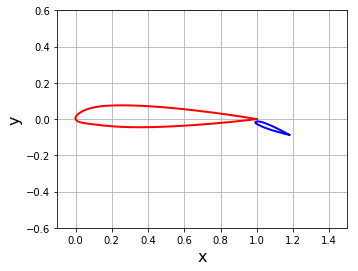

In [119]:
#plot to check function
py.figure(figsize=(8,4))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(xmain, ymain, color='r', linestyle='-', linewidth=2)
py.plot(xnew, ynew, color='b', linestyle='-', linewidth=2)

py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.5)
py.ylim(-0.6, 0.6);

In [78]:
#lift caluclator
def lift_calc(panels, Asource, Bvortex, AoA, stream):
    
    
    freestream = Freestream(stream, AoA)
    
    A = build_singularity_matrix(Asource, Bvortex)
    b = build_freestream_rhs(panels, freestream)
    
    sigmas = np.linalg.solve(A, b)
    
    #store source strength
    for i, panel in enumerate(pannels):
        panel.sigma = sigmas[i]
    gamma = sigmas[-2:]
    
    compute_tangential_velocity(pannels, freestream, gamma, 
                                Asource, Bvortex)
    compute_pressure_coefficient(pannels, freestream)
    l = 0.0
    for panel in pannels:
        l -= panel.cp*np.sin(panel.beta)*panel.length
        
    return l

In [79]:
def bisection1(panels, Asource, Bvortex, stream, range1, range2, tol):

    lift1 = lift_calc(panels, Asource, Bvortex, range1, stream)
    
    n = 1
    while n < 20:
        alpha = (range1+range2)/2
        lift = lift_calc(panels, Asource, Bvortex, alpha, stream)
        print('Guess', n,':', -alpha, 'Lift:', lift)
        
        if abs(range2-range1)/2 < tol: 
            break
        
        
        if np.sign(lift) == np.sign(lift1):
            range1 = alpha
            lift1=lift
        else:
            range2 = alpha
    
        n = n+1
    return alpha

In [81]:
#What angle of attack will cause 0 lift w/ a flap angle of 20deg?
AoA = bisection1(part1, Asource, Bvortex, 1.0, 14, -14, 0.01)

1 Guess: 0.0 Lift: 1.52018626053
2 Guess: -7.0 Lift: 0.548338462552
3 Guess: -10.5 Lift: 0.0634989062041
4 Guess: -12.25 Lift: -0.175476948754
5 Guess: -11.375 Lift: -0.0563695467263
6 Guess: -10.9375 Lift: 0.00347652142469
7 Guess: -11.15625 Lift: -0.0264694255558
8 Guess: -11.046875 Lift: -0.0115020712276
9 Guess: -10.9921875 Lift: -0.00401416604986
10 Guess: -10.96484375 Lift: -0.000269168393877
11 Guess: -10.951171875 Lift: 0.00160359020835
12 Guess: -10.9580078125 Lift: 0.000667189303812


In [103]:
def lift_calc2(xmain, ymain, xflap, yflap, stream, AoA, theta):
    
    main = define_panels(xmain, ymain, 150)
    xrot, yrot = rotate(1.03, -0.054, xflap, yflap, theta)
    rot = define_panels(xrot, yrot, 150)
    part2 = np.append(main, rot)
    Asource = source_contribution_normal(part2)
    Bvortex = vortex_contribution_normal(part2)
    
    freestream = Freestream(stream, AoA)
    
    A = build_singularity_matrix(Asource, Bvortex)
    b = build_freestream_rhs(part2, freestream)
    
    sigmas = np.linalg.solve(A, b)
    
    #store source strength
    for i, panel in enumerate(part2):
        panel.sigma = sigmas[i]
    gamma = sigmas[-2:]
    
    compute_tangential_velocity(part2, freestream, gamma, Asource, Bvortex)
    compute_pressure_coefficient(part2, freestream)
    l = 0.0
    for panel in part2:
        l -= panel.cp*np.sin(panel.beta)*panel.length
        
        
    drag = 0
    for panel in part2:
        drag -= panel.cp*np.cos(panel.beta)*panel.length
        
    return l, drag

In [104]:
def bisection2(xmain, ymain, xflap, yflap, stream, range1, range2, tol):

    
    lift1, drag = lift_calc2(xmain, ymain, xflap, yflap, 1.0, 0.0, range1)
    
    n = 1
    while n < 20:
        alpha = (range1+range2)/2
        lift, drag = lift_calc2(xmain, ymain, xflap, yflap, 
                                1.0, 0.0, alpha)
        print('Guess', n,':', -alpha, 'Lift:', lift)
        
        if abs(range2-range1)/2 < tol: 
            break
        
        
        if np.sign(lift) == np.sign(lift1):
            range1 = alpha
            lift1=lift
        else:
            range2 = alpha
    
        n = n+1
    return alpha

In [98]:
flaplift, drag = bisection2(xmain, ymain, xflap, yflap, 
                            1.0, -10.0, 10.0, 0.01)

1 Guess: 0.0 Lift: 0.271910644469
2 Guess: 5.0 Lift: -0.0292849385314
3 Guess: 2.5 Lift: 0.120733957722
4 Guess: 3.75 Lift: 0.0455783940188
5 Guess: 4.375 Lift: 0.00811001236125
6 Guess: 4.6875 Lift: -0.010596666081
7 Guess: 4.53125 Lift: -0.00124562455172
8 Guess: 4.453125 Lift: 0.0034316198606
9 Guess: 4.4921875 Lift: 0.00109285409623
10 Guess: 4.51171875 Lift: -7.64211232741e-05
11 Guess: 4.501953125 Lift: 0.000508207513369


In [105]:
#Q3
#Lift at 0 , 5, 10, 15 deg of flap tilt
lift0, drag0 = lift_calc2(xmain, ymain, xflap, yflap, 1.0, 4.0, 0)
lift5, drag5 = lift_calc2(xmain, ymain, xflap, yflap, 1.0, 4.0, -5)
lift10, drag10 = lift_calc2(xmain, ymain, xflap, yflap, 1.0, 4.0, -10)
lift15, drag15 = lift_calc2(xmain, ymain, xflap, yflap, 1.0, 4.0, -15)

In [114]:
perc5 = (1 - 1/np.sqrt(drag5/drag0))*100
perc10 = (1 - 1/np.sqrt(drag10/drag0))*100
perc15 = (1 - 1/np.sqrt(drag15/drag0))*100
print('From 0deg to 5deg:', perc5, 
      '\nFrom 0deg to 10deg:', perc10, 
      '\nFrom 0deg to 15deg:', perc15)

From 0deg to 5deg: 14.638214654 
From 0deg to 10deg: 24.3906650305 
From 0deg to 15deg: 31.4816713037
